In [1]:
import cv2
import numpy as np
from PIL import Image
import json
import copy
import torch
from craft_text_detector import get_prediction
from craft_text_detector.file_utils import rectify_poly
from craft_text_detector import load_craftnet_model, load_refinenet_model
from model import *

def non_max_suppression_fast(boxes, overlapThresh=0.5):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if isinstance(boxes[0], list):
        boxes = np.array(boxes)
    #
    # initialize the list of picked indexes
    pick = []
    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked using the
    # integer data type
    # final_boxes = boxes[pick].astype("int")
    # return final_boxes
    return pick

def expand_box(poly, pct_up, pct_down): 
    h = min(poly[3][1]-poly[0][1], poly[2][1]-poly[1][1])
    if poly[0][1] - pct_up * h < 0 :
        poly[0][1] = 0
    else:
        poly[0][1] = poly[0][1] - pct_up * h
    if poly[1][1] - pct_up * h < 0:
        poly[1][1] = 0
    else:
        poly[1][1] = poly[1][1] - pct_up * h
    poly[2][1] = poly[2][1] + pct_down * h
    poly[3][1] = poly[3][1] + pct_down * h
    return poly

def post_process(polys, thresh, pct_up, pct_down ): 
    merged = []
    for i in range(len(polys)): 
        arr = []
        for j in range(len(polys)):
            if i != j and  polys[i][3][1] + 0.5 * (polys[i][3][1]-polys[i][0][1]) > polys[j][3][1] >  polys[i][3][1] - 0.5 * (polys[i][3][1]-polys[i][0][1]) :  
                arr.append( (polys[i][3][1]- polys[i][0][1]) /(polys[j][3][1]-polys[j][0][1]) )
        if len(arr) > 0 : 
            tb = sum(arr) / len(arr)  
            # print(tb)
            if thresh < tb : 
                # print("ssssssssssssssssssssssssssssssssssssss")
                add = np.copy(polys[i])
                polys[i][2][1] = (polys[i][2][1] + polys[i][1][1])/2 
                polys[i][3][1] = (polys[i][3][1] + polys[i][0][1])/2 
                add[1][1] = polys[i][2][1]
                add[0][1] = polys[i][3][1]
                merged.append(add)
        else: 
            if pct_down != 0 or pct_up != 0: 
                polys[i] = expand_box(poly=polys[1], pct_up=pct_up, pct_down=pct_down)
    # print('merged ' , len(merged))
    merged = np.array(merged)
    # print('post merged ' , merged.shape)
    # print('polys ', polys.shape) 
    # print('polys type', type(polys)) 
    polys = list(polys)
    
    for add in merged: 
        polys.append(add)
    
    polys = np.array(polys)
    # print('post polys ', polys.shape)  
    # print('post type polys ', type(polys))  
    return polys 

def extract_text_box(img, craft_net, cuda=False, device="cpu"):
    img = copy.deepcopy(img)
    prediction_result = get_prediction(
        image=img,
        craft_net=craft_net,
        text_threshold=0.7,
        link_threshold=0.4,
        low_text=0.4,
        cuda=cuda,
        device=device,
        long_size=1280
    )

    result_list = []
    # print(type(prediction_result["boxes"]), prediction_result["boxes"].shape)
    # print(prediction_result["boxes"])
    # print(prediction_result["boxes"].shape)

    # unique_bbox = group_bbox_by_iou_quad(prediction_result["boxes"].tolist(), 0.5)
    polys = post_process(prediction_result["boxes"].tolist(), 2.2, 0.1, 0.05)
    exist_bboxes = []
    for region in polys :
        x1, y1 = np.min(region, axis=0)
        x2, y2 = np.max(region, axis=0)
        bbox = [int(x1), int(y1), int(x2), int(y2)]

        if bbox not in exist_bboxes:
            result_list.append((bbox, np.array(rectify_poly(img, region))))
            exist_bboxes.append(bbox)
    del exist_bboxes
    pick_bbox = non_max_suppression_fast([box[0] for box in result_list])
    print(pick_bbox)
    return [result_list[pick] for pick in pick_bbox], result_list
    # return result_list

def extract_text_box_phrase(img, craft_net, refine_net, cuda=False, device="cpu"):
        img = copy.deepcopy(img)
        # self.show_img(img)
        prediction_result = get_prediction(
            image=img,
            craft_net=craft_net,
            refine_net=refine_net,
            text_threshold=0.7,
            link_threshold=0.4,
            cuda=cuda,
            device=device,
            low_text=0.4,
            long_size=1280
        )
        result_list = []
        for region in prediction_result["boxes"] :
            x1, y1 = np.min(region, axis=0)
            x2, y2 = np.max(region, axis=0)
            result_list.append(
                [int(x1), int(y1), int(x2), int(y2)])

        list_phrase = []
        for box_phrases in prediction_result["boxes"]:
            phrase = []
            for coordinate in box_phrases:
                coordinate_tranform = convert2list(coordinate)
                phrase.append(coordinate_tranform)

            list_phrase.append(phrase)

        return list_phrase, result_list
    
class DETECT():
    def __init__(self, weight_path = './mnt/disk1/mbbank/hieu_doan/weights/craft_v1.pth', device='cpu') -> None:
        if device == 'cpu':
            self.cuda = False
        else:
            self.cuda = True
        self.device = device
        self.craft_net = load_craftnet_model(cuda=False, weight_path=weight_path)
        self.refine_net = load_refinenet_model(cuda=False)

        if self.cuda : 
            self.craft_net = self.craft_net.to(torch.device(device))
            self.refine_net = self.refine_net.to(torch.device(device))

    def bbox_detect(self, img_p):
        try:
            if isinstance(img_p, str):
                img = cv2.imread(img_p)
            else:
                imgarr = np.asarray(bytearray(img_p), dtype=np.uint8)
                img = cv2.imdecode(imgarr, cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            width, height = img.shape[1], img.shape[0]
        except:
            image = Image.open(img_p)
            image = image.convert("RGB")
            width, height = image.size
            img = np.array(image)
        # img = img_p.copy()
        list_bbox = extract_text_box(img, self.craft_net, cuda= self.cuda, device=self.device)

        return list_bbox
    
    def bbox_detect_phrase(self, img_p, read_image=True):
        if read_image:
            try:
                if isinstance(img_p, str):
                    img = cv2.imread(img_p)
                elif type(img_p) != np.array: 
                    imgarr = np.asarray(bytearray(img_p), dtype=np.uint8)
                    img = cv2.imdecode(imgarr, cv2.IMREAD_COLOR)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            except:
                image = Image.open(img_p)
                image = image.convert("RGB")
                img = np.array(image)
        else:
            img = img_p.copy()

        list_bbox = extract_text_box_phrase(img, self.craft_net, self.refine_net, cuda= self.cuda, device=self.device)

        return list_bbox
    




<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
det = DETECT(weight_path="./weights/craft_v1.pth", device='cuda:3')
# det = DETECT(device='cpu') 



/mnt/disk1/mbbank/miniconda3/envs/gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:252: UserWarning: Accessing the model URLs via the internal dictionary of the module is deprecated since 0.13 and will be removed in 0.15. Please access them via the appropriate Weights Enum instead.
  warnings.warn(
/mnt/disk1/mbbank/miniconda3/envs/gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/mnt/disk1/mbbank/miniconda3/envs/gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [3]:
img_path = './19.jpg'
phare, org = det.bbox_detect_phrase(img_path, read_image=True)

/mnt/disk1/mbbank/miniconda3/envs/gpu/lib/python3.8/site-packages/craft_text_detector/craft_utils.py:415: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  polys = np.array(polys)
/mnt/disk1/mbbank/miniconda3/envs/gpu/lib/python3.8/site-packages/craft_text_detector/predict.py:112: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  polys_as_ratio = np.array(polys_as_ratio)


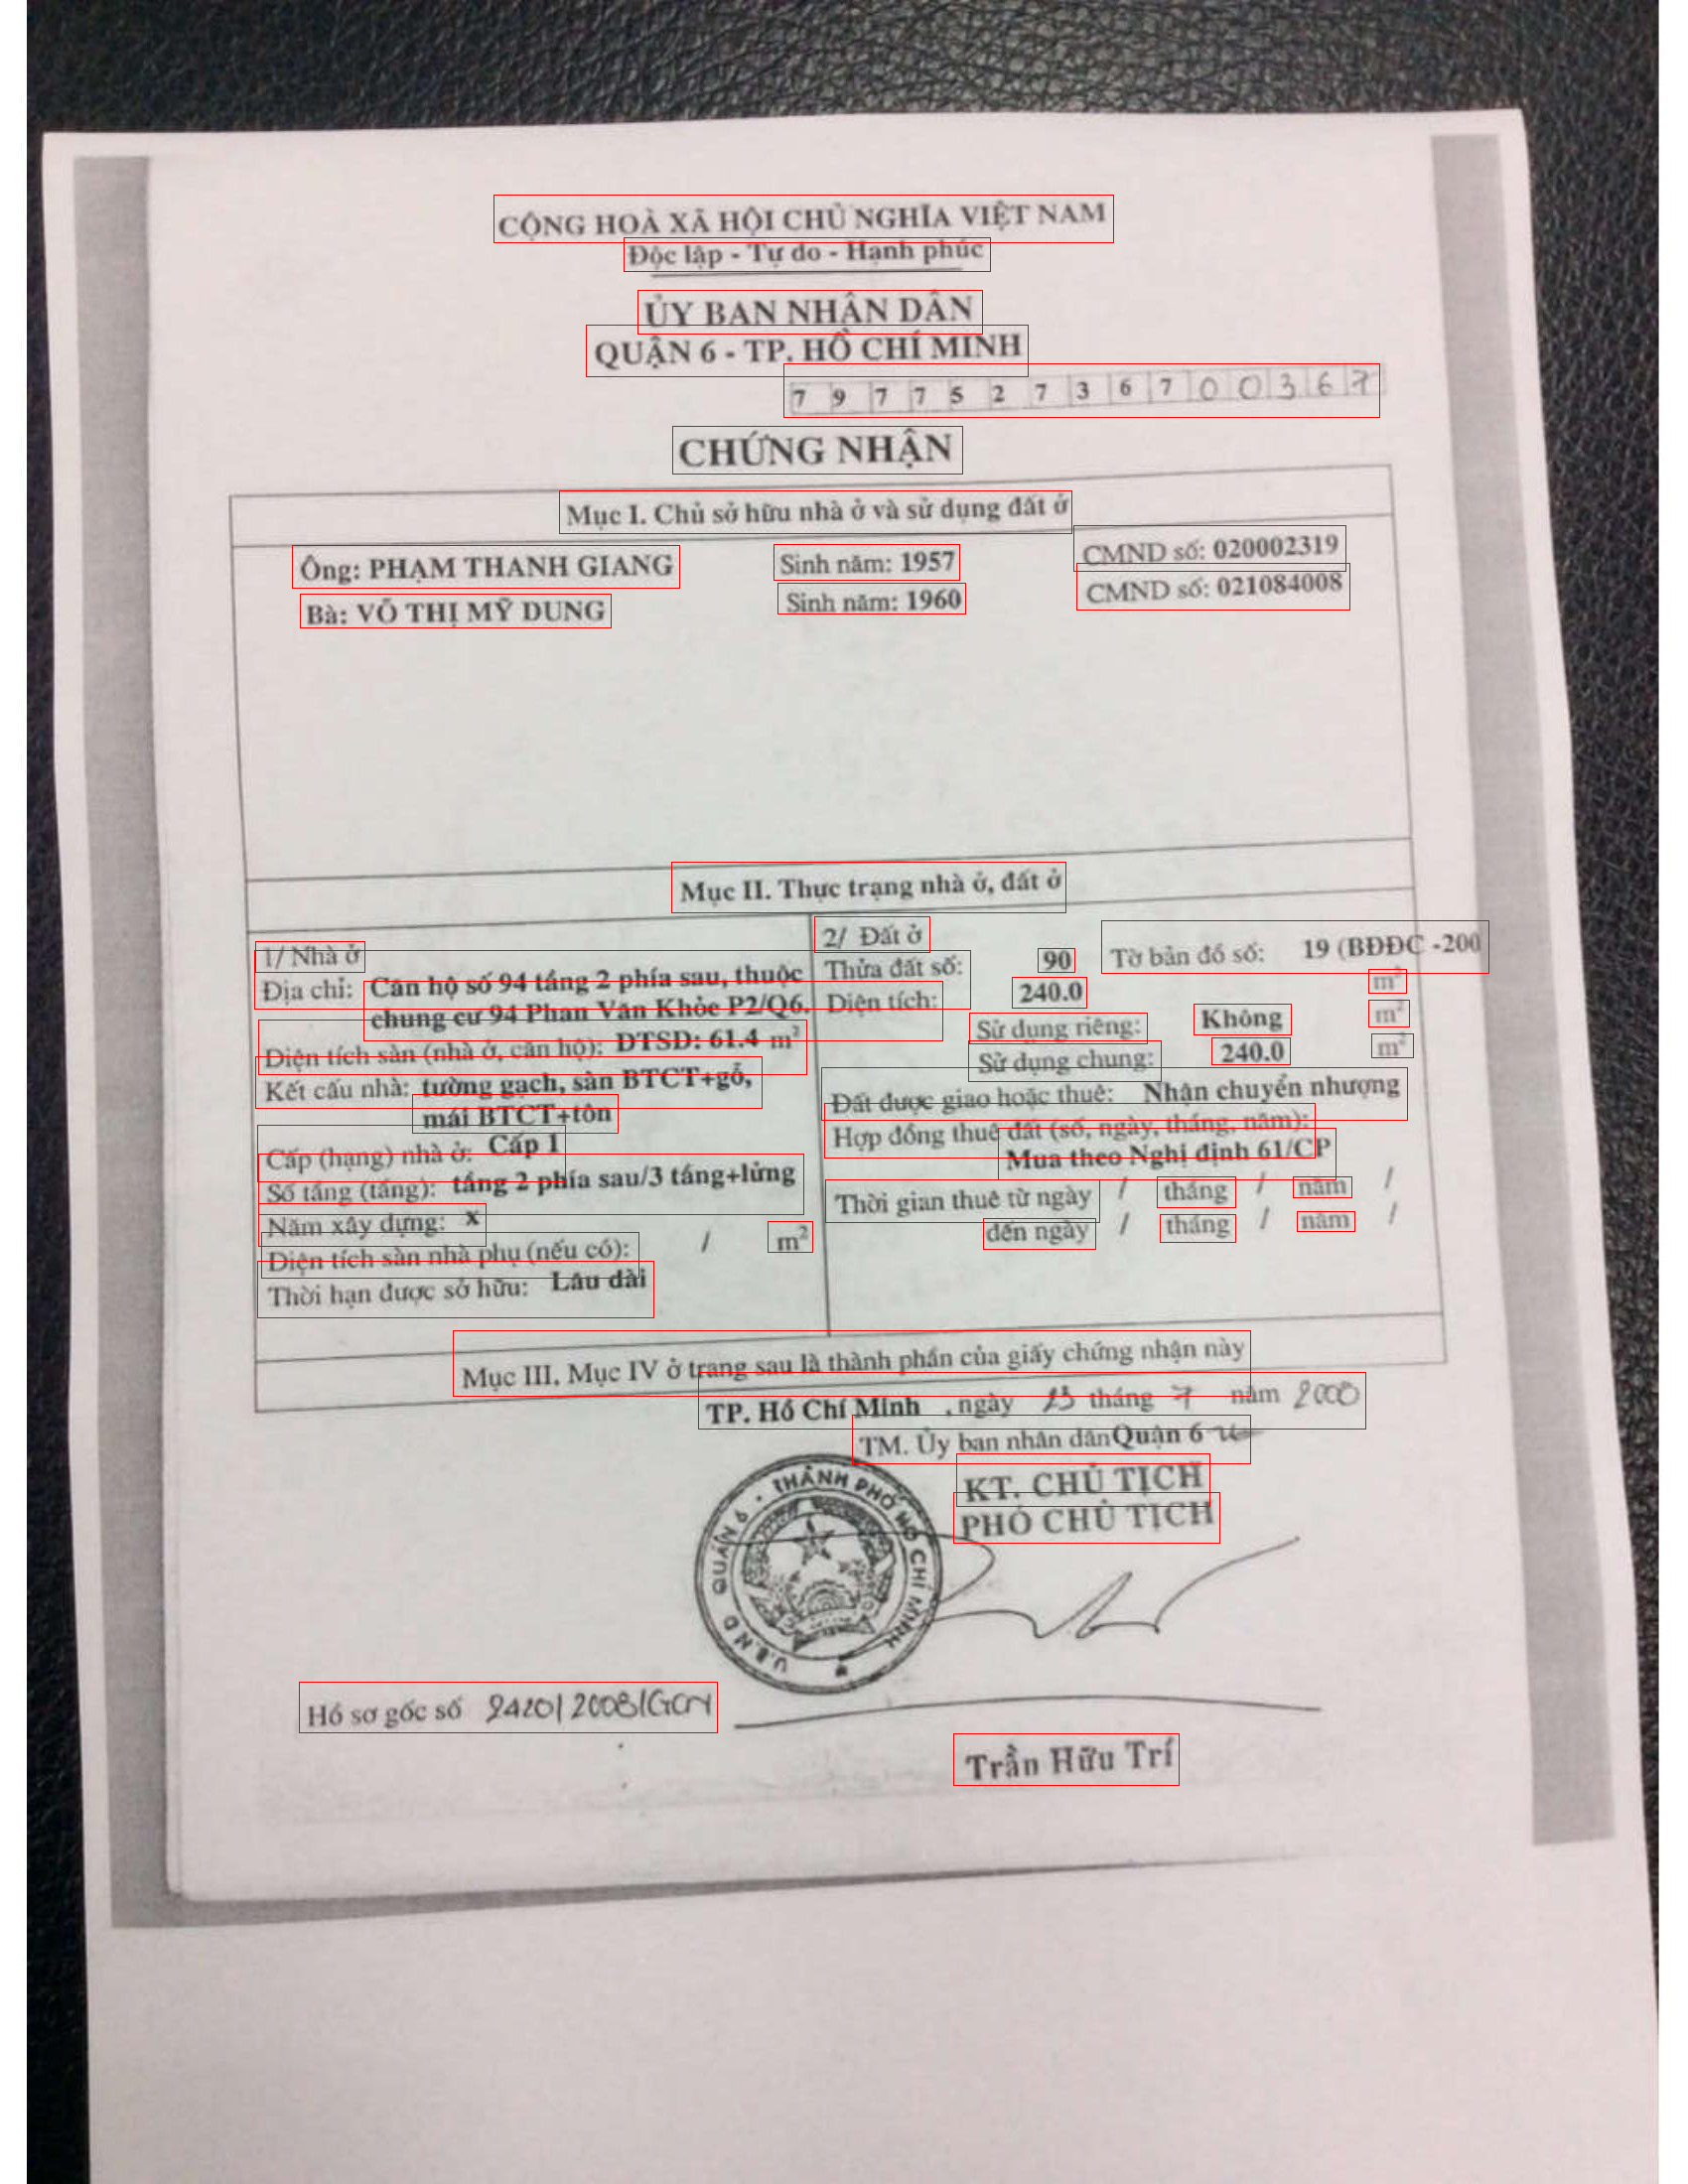

: 

In [6]:
from PIL import Image, ImageDraw, ImageFont

image = Image.open(img_path)
image = image.convert('RGB')
draw = ImageDraw.Draw(image)
font = ImageFont.load_default()
for bbox in org:
    draw.rectangle(bbox, outline='red')

# for bbox in nms:
#     draw.rectangle(bbox[0], outline='blue')

image

In [ ]:

org.append(([565, 15, 650, 42], 'a'))
org.append(([135, 272, 160, 280], 'a'))


In [ ]:
[org[pick][0] for pick in [1,2,3,4]]

[[429, 34, 470, 56],
 [196, 35, 246, 56],
 [245, 35, 282, 53],
 [282, 35, 307, 53]]

In [ ]:
pick_bbox = non_max_suppression_fast([org[pick][0] for pick in range(len(org))])
nms_new = [org[pick][0] for pick in pick_bbox]

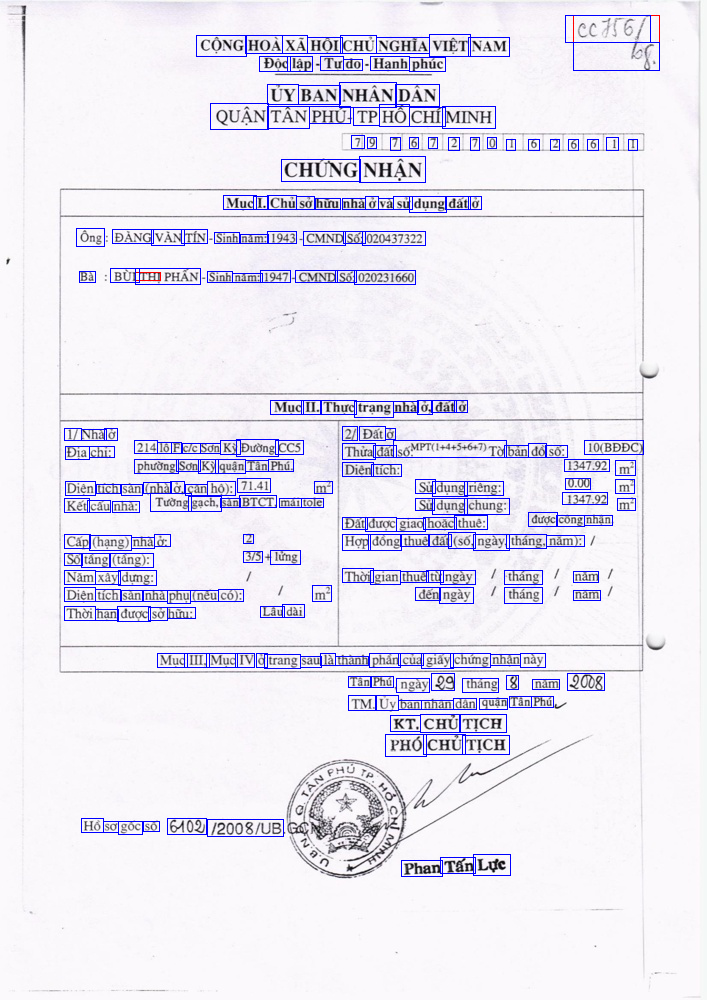

In [ ]:
from PIL import Image, ImageDraw, ImageFont

image = Image.open(img_path)
image = image.convert('RGB')
draw = ImageDraw.Draw(image)
font = ImageFont.load_default()
for i, bbox in enumerate(org):
    draw.rectangle(bbox[0], outline='red')
#     if i%2 == 0:
#         draw.text((bbox[0][0] + 10, bbox[0][1] - 10),
#                         text=str(i), fill='red', font=font)
#     else:
#         draw.text((bbox[0][0] - 10, bbox[0][1] + 10),
#                         text=str(i), fill='black', font=font)
for bbox in nms_new:
    draw.rectangle(bbox, outline='blue')
    # draw.text((bbox[0] + 15, bbox[1] - 15),
    #                   text=str(i), fill='blue', font=font)
image